# <p style="text-align: center;">Long Short Term Memory (LSTM) example in Keras <br>for predicting time series
</p>

<p style="text-align: center;">
 by Prof. Dr.-Ing. Jürgen Brauer, http://www.juergenbrauer.org
</p>

# Table of Contents

1. Load the training and test data
2. Display some of the training data
3. Display some of the test data
4. Output format to submit for the competition
5. Extract a single time series
6. Display the extracted sales time series of a single store
7. Prepare the training data for the LSTM
8. Build the Keras model and train it
9. Test prediction on train data

## 1. Load the training and test data

Dataset is from Kaggle:
https://www.kaggle.com/c/rossmann-store-sales/data

In [1]:
import pandas as pd
train_data = pd.read_csv("rossmann_dataset/train.csv")
test_data  = pd.read_csv("rossmann_dataset/test.csv")

C:\Users\Juergen Brauer\AppData\Local\conda\conda\envs\env_mss\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 2. Display some of the training data

Let's first get a feeling for the training data:

In [2]:
print("train_data has shape", train_data.shape)
train_data.head(10)

train_data has shape (1017209, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
5,6,5,2015-07-31,5651,589,1,1,0,1
6,7,5,2015-07-31,15344,1414,1,1,0,1
7,8,5,2015-07-31,8492,833,1,1,0,1
8,9,5,2015-07-31,8565,687,1,1,0,1
9,10,5,2015-07-31,7185,681,1,1,0,1


The "Sales" column in the dataset is the turnover that was made at a specific day in a specific store.

Here is more information on the data from the Kaggle competition website:
    
    Id - an Id that represents a (Store, Date) duple within the test set
    
    Store - a unique Id for each store
    
    Sales - the turnover for any given day (this is what you are predicting)
    
    Customers - the number of customers on a given day
    
    Open - an indicator for whether the store was open: 0 = closed, 1 = open
    
    StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
    
    SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
    

Now let us display histograms for some of the data columns:

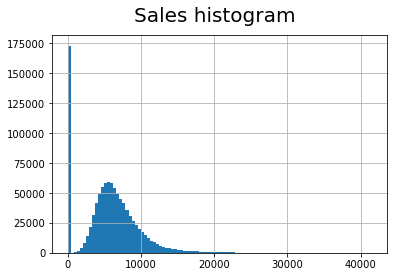

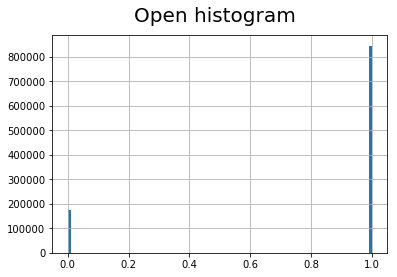

In [3]:
import matplotlib.pyplot as plt

train_data["Sales"].hist(bins=100)
plt.suptitle("Sales histogram", fontsize=20)
plt.show()

train_data["Open"].hist(bins=100)
plt.suptitle("Open histogram", fontsize=20)
plt.show()

## 3. Display some of the test data

Now let us get a feeling for the test data:

In [4]:
print("test_data has shape", test_data.shape)
test_data.head(10)

test_data has shape (41088, 8)


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
5,6,10,4,2015-09-17,1.0,1,0,0
6,7,11,4,2015-09-17,1.0,1,0,0
7,8,12,4,2015-09-17,1.0,1,0,0
8,9,13,4,2015-09-17,1.0,1,0,0
9,10,14,4,2015-09-17,1.0,1,0,0


There are 41088 rows for which we have to predict the sales. Note that the "Sales" and "Customers" columns are missing!

So given a certain "Store" id and additional information as "DayOfWeek", "Data", "Open", "Promo", "StateHoliday" and "SchoolHoliday" we have to predict the sales / turnover for this store.

Note, that there are some stores "missing" in the test table (e.g., stores with ID 2,4,5,6). So for these stores we are not expected to give predictions.

## 4. Output format to submit for the competition

If you have a look at sample_submission.csv you will see that we are expected to give predictions for each of the 41088 rows:

In [5]:
sample_submission = pd.read_csv("rossmann_dataset/sample_submission.csv")
print("sample_submission has shape", sample_submission.shape)
sample_submission.head(10)

sample_submission has shape (41088, 2)


,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


## 5. Extract a single time series

Now let us extract the sales time series for a single store from the training data.

In [28]:
train_data_store1 = train_data[train_data.Store == 1]
print("train_data_store1 has shape", train_data_store1.shape)
train_data_store1.head(10)

train_data_store1 has shape (942, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1115,1,4,2015-07-30,5020,546,1,1,0,1
2230,1,3,2015-07-29,4782,523,1,1,0,1
3345,1,2,2015-07-28,5011,560,1,1,0,1
4460,1,1,2015-07-27,6102,612,1,1,0,1
5575,1,7,2015-07-26,0,0,0,0,0,0
6690,1,6,2015-07-25,4364,500,1,0,0,0
7805,1,5,2015-07-24,3706,459,1,0,0,0
8920,1,4,2015-07-23,3769,503,1,0,0,0
10035,1,3,2015-07-22,3464,463,1,0,0,0


Mmmhhh... The resulting data is in reverse time order when looking at the date. Let's sort the table according to the date:

In [29]:
train_data_store1.sort_values(by=['Date'], inplace=True, ascending=True)
train_data_store1.head(15)

C:\Users\Juergen Brauer\AppData\Local\conda\conda\envs\env_mss\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1016095,1,2,2013-01-01,0,0,0,0,a,1
1014980,1,3,2013-01-02,5530,668,1,0,0,1
1013865,1,4,2013-01-03,4327,578,1,0,0,1
1012750,1,5,2013-01-04,4486,619,1,0,0,1
1011635,1,6,2013-01-05,4997,635,1,0,0,1
1010520,1,7,2013-01-06,0,0,0,0,0,1
1009405,1,1,2013-01-07,7176,785,1,1,0,1
1008290,1,2,2013-01-08,5580,654,1,1,0,1
1007175,1,3,2013-01-09,5471,626,1,1,0,1
1006060,1,4,2013-01-10,4892,615,1,1,0,1


In [49]:
col_dates = train_data_store1["Date"].values
col_sales = train_data_store1["Sales"].values
col_open  = train_data_store1["Open"].values

SCALE_DATA = True

if SCALE_DATA:    
    col_sales = col_sales / 10000.0
    #print("col_sales = ", col_sales)

print("shape of col_dates is", col_dates.shape)
print("shape of col_sales is", col_sales.shape)
print("shape of col_open is", col_open.shape)

shape of col_dates is (942,)
shape of col_sales is (942,)
shape of col_open is (942,)


## 6. Display the extracted sales and open time series

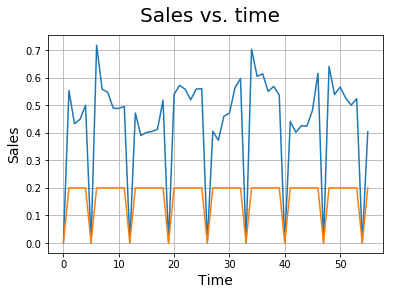

In [51]:
import matplotlib.pyplot as plt

nr_days_twomonths = 7*4 + 7*4

fig = plt.figure("Sales for store 1")
fig.suptitle("Sales vs. time", fontsize=20)
plt.plot(col_sales[0:nr_days_twomonths])
plt.plot(col_open[0:nr_days_twomonths]*0.2)
plt.grid(True)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Sales", fontsize=14)
plt.show()

## 7. Prepare the training data for the LSTM

In [52]:
# The training data input for the Keras LSTM has to be matrix dataX
# with shape:
#   [samples, time steps, features]    

import numpy as np
from sklearn.preprocessing import MinMaxScaler

def to_sequence_data(inp_series1, inp_series2, out_series, n=3, m=1):
    dataX, dataY = [], []
    for i in range( len(inp_series1)-n-1 ):
        col1 = inp_series1[ i   : i+n ]        
        col2 = inp_series2[ i+1 : i+n+1 ]
        
        M = np.zeros((n,2))
        M[:,0] = col1
        M[:,1] = col2
                
        dataX.append( M )
                
        dataY.append( out_series[ i+n : i+n+m ] )
    return np.array(dataX), np.array(dataY)

trainX, trainY = to_sequence_data(col_sales,col_open,col_sales,3,1)

nr_training_samples = trainX.shape[0]
print("I have generated", nr_training_samples, "training samples.")

print("Shape of trainX is", trainX.shape)
print("Shape of trainY is", trainY.shape)

print("\n",trainX[0], "-->", trainY[0])
print("\n",trainX[1], "-->", trainY[1])
print("\n",trainX[2], "-->", trainY[2])
print("\n",trainX[3], "-->", trainY[3])

print("\n")
print(col_sales[0:10])
print(col_open[0:10])

I have generated 938 training samples.
Shape of trainX is (938, 3, 2)
Shape of trainY is (938, 1)

 [[0.     1.    ]
 [0.553  1.    ]
 [0.4327 1.    ]] --> [0.4486]

 [[0.553  1.    ]
 [0.4327 1.    ]
 [0.4486 1.    ]] --> [0.4997]

 [[0.4327 1.    ]
 [0.4486 1.    ]
 [0.4997 0.    ]] --> [0.]

 [[0.4486 1.    ]
 [0.4997 0.    ]
 [0.     1.    ]] --> [0.7176]


[0.     0.553  0.4327 0.4486 0.4997 0.     0.7176 0.558  0.5471 0.4892]
[0 1 1 1 1 0 1 1 1 1]


## 8. Build the Keras model and train it

In [53]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

nr_inp_time_steps = 3
nr_input_features = 2

model = Sequential()
model.add(LSTM(4, input_shape=(nr_inp_time_steps, nr_input_features)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')    
model.fit(trainX,
          trainY,
          epochs=200,
          batch_size=32,
          verbose=2)

Epoch 1/200
 - 0s - loss: 0.2407
Epoch 2/200
 - 0s - loss: 0.1629
Epoch 3/200
 - 0s - loss: 0.1055
Epoch 4/200
 - 0s - loss: 0.0663
Epoch 5/200
 - 0s - loss: 0.0463
Epoch 6/200
 - 0s - loss: 0.0404
Epoch 7/200
 - 0s - loss: 0.0392
Epoch 8/200
 - 0s - loss: 0.0385
Epoch 9/200
 - 0s - loss: 0.0378
Epoch 10/200
 - 0s - loss: 0.0371
Epoch 11/200
 - 0s - loss: 0.0364
Epoch 12/200
 - 0s - loss: 0.0357
Epoch 13/200
 - 0s - loss: 0.0351
Epoch 14/200
 - 0s - loss: 0.0344
Epoch 15/200
 - 0s - loss: 0.0337
Epoch 16/200
 - 0s - loss: 0.0330
Epoch 17/200
 - 0s - loss: 0.0324
Epoch 18/200
 - 0s - loss: 0.0316
Epoch 19/200
 - 0s - loss: 0.0310
Epoch 20/200
 - 0s - loss: 0.0303
Epoch 21/200
 - 0s - loss: 0.0295
Epoch 22/200
 - 0s - loss: 0.0287
Epoch 23/200
 - 0s - loss: 0.0280
Epoch 24/200
 - 0s - loss: 0.0272
Epoch 25/200
 - 0s - loss: 0.0265
Epoch 26/200
 - 0s - loss: 0.0256
Epoch 27/200
 - 0s - loss: 0.0248
Epoch 28/200
 - 0s - loss: 0.0240
Epoch 29/200
 - 0s - loss: 0.0231
Epoch 30/200
 - 0s - lo

## 9. Test prediction on train data

Shape of trainPredict is (938, 1)


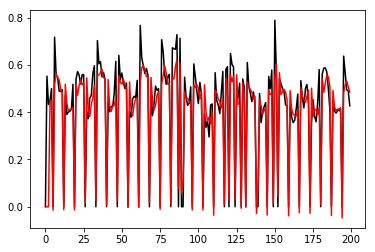

In [59]:
DAYS_TO_SHOW=200

trainPredict = model.predict(trainX)
print("Shape of trainPredict is", trainPredict.shape)
trainPredict = trainPredict.reshape(-1)
#print(trainPredict)

# plot ground truth time series
plt.plot(col_sales[0:DAYS_TO_SHOW], "black")

# plot calculated time series
graph_pred_train = np.zeros(nr_inp_time_steps+len(trainPredict))
graph_pred_train[nr_inp_time_steps:] = trainPredict
plt.plot(graph_pred_train[0:DAYS_TO_SHOW], "red")

plt.show()